<a href="https://colab.research.google.com/github/mirpouya/GANs/blob/main/Introduction_to_DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> 1. Downloading the Dataset </h1>

In [1]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pouyammsadeghi
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:04<00:00, 96.5MB/s]


In [5]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [6]:
print(os.listdir(DATA_DIR+'/images')[:10])

['47357_2014.jpg', '40150_2012.jpg', '59421_2018.jpg', '2206_2001.jpg', '31242_2010.jpg', '29433_2010.jpg', '39358_2012.jpg', '19860_2007.jpg', '5988_2003.jpg', '49913_2015.jpg']


<b> Visualizing some of the data <'/b>

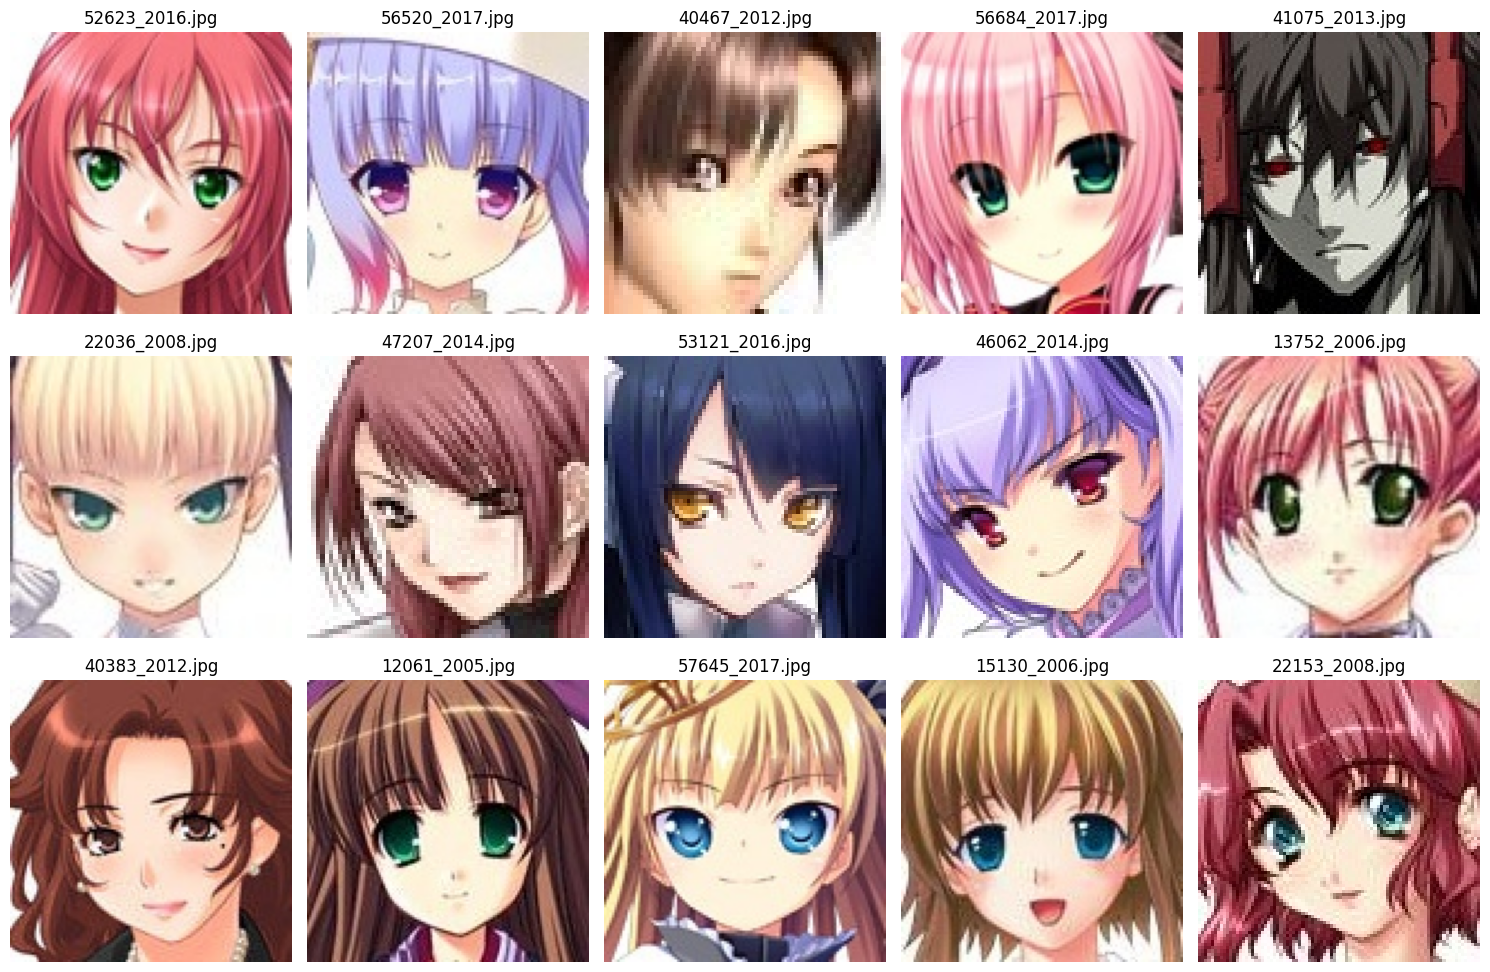

In [20]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Path to the directory containing the images
dataset_dir = "/content/animefacedataset/images"

# Get a list of all image files
image_files = os.listdir(dataset_dir)

# Select 15 random images
random_images = random.sample(image_files, 15)

# Define the size of the grid for subplots
rows = 3
cols = 5

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Loop through each random image and plot it
for i, image_name in enumerate(random_images):
    # Open the image
    image_path = os.path.join(dataset_dir, image_name)
    image = Image.open(image_path)

    # Plot the image on the corresponding subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis

    # Set subplot title as the image filename
    axes[i].set_title(image_name)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [7]:
# DataLoader
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

<b> STEPS </B>
* RESIZE and CROP images to (64, 64)
* NORMALIZE pixel values in range of (-1, 1) in each channel
* create DATALOADER to load the data into batches

In [8]:
image_size = 64
batch_size = 128

# normalizing with mean of 0.5 and std of 0.5 in each channel
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

<font color='blue'> <b> QUESTION: </b> </font>
what is ImageFolder used for?

In [12]:
train_dataset = ImageFolder(
    DATA_DIR,
    transform = T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)]
    )
)

In [18]:
# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [38]:
# LIBRARIES
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

<h1> <b> Using GPU </b> </h1>

Defining a set of `helper functions` to:
* check availability of GPU
* Moving data to GPU
* Moving model to GPU <br>
if available

In [21]:
def get_default_device():
  """
  pick GPU if available, else CPU
  """
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")


def to_device(data, device):
  """ Move data (tensors) into chosen device """
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
    # recursively move all the elements in list or tuple to GPU
  return data.to(device, non_blocking=True)

In [22]:
class DeviceDataLoader():
  """
  wrap a dataloader to move data to a device
  """

  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ yield a batch of data after moving it to the device """
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches """
    return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cpu')

now with `DeviceDataLoader` we can automatically transfer data to the GPU

In [24]:
train_dl = DeviceDataLoader(train_dataloader, device)

<h1> <b> 2. Discriminator Network </b> </h1>

Discriminator network is a CNN with binary output, it determines if an image is real or generated by Generator network. In this sense, it is like any other conventional image classifier like VGG16, ResNet, InceptionNet, ...

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`

<b> output shape of a convolutional layer </b>

$ \large \text{Output size} = \frac{\text{Input size} + 2 \times \text{padding} - \text{kernel size} - 1}{\text{stride}} + 1 $


In [28]:
discriminator = nn.Sequential(
    # input size: (3, 64, 64)

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # output shape: 64 * 32 * 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # output shape: 128 * 16 * 16

    nn.Conv2d(in_channels=128, out_channels=265, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # output shape: 256 * 8 * 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # output shape: 512 * 4 * 4

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0, bias=False),
    # output shape: 1 * 1 * 1

    nn.Flatten(),
    nn.Sigmoid()
)

<b> LeakyReLU activation function: </b>

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">

In [30]:
# moving discriminator to GPU if available

discriminator = to_device(discriminator, device)

<h1> <b> 3. Generator Network </b> </h1>

The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [31]:
latent_size = 128

`torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)`

$ \large \text{Output size} = (\text{Input size} - 1) \times \text{stride} - 2 \times \text{padding} + \text{kernel size} + \text{output padding} $

In [33]:
generator = nn.Sequential(
    # input: latent_size * 1 * 1

    nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 * 8 * 8

    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 * 16 * 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

The last layer has `tanh` activation for mapping input between (-1, 1) since in the normalization process we normalize pixel values in the range of (-1, 1)

NOTE another time that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

In [34]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [35]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

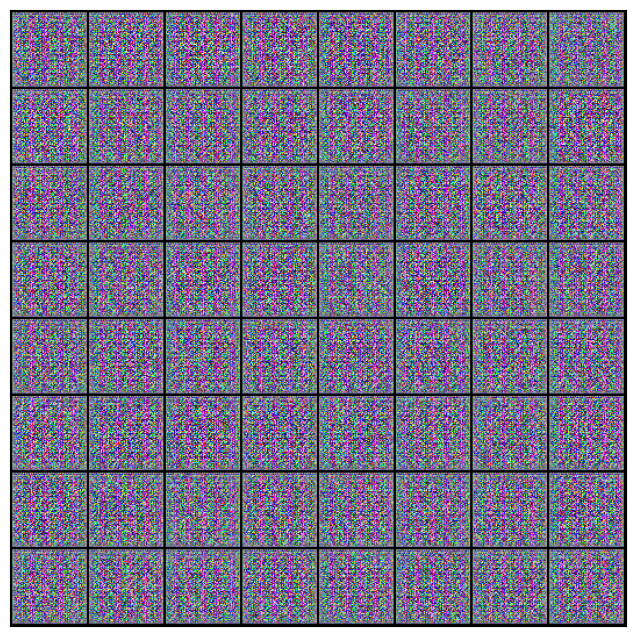

In [36]:
# making randonm latent tensors
xb = torch.randn(batch_size, latent_size, 1, 1)

fake_images = generator(xb)
show_images(fake_images)

In [37]:
# move generator to GPU if available
generator = to_device(generator, device)

<h1> <b> 4. Discriminator Training </b> </h1>

Discriminator is a binary classification, therefore we can use the binary cross entropy loss for its training.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [42]:
def train_discriminator(real_images, opt_d):
  # clear discriminator gradients
  opt_d.zero_grad()

  # pass real images to discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, devive=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # discriminator predicitons
  fake_preds = discriminator(fake_images)
  fake_targets = torch.ones(fake_images.size(0), 1, device=device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

<h1> <b> Generator Training </b> </h1>

The output of generator is some images or noises, hence it is difficult to define a directl loss function for measuring it is doing good. As a result, we need to employ an indirect way of performance measurement and training

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.